# **Convolutional Neural Network Filter Bank for Musical Instruments Classification**

# Professor Supervisor: Prof. Gerald Schuller
# Research Assistant Supervisor: Renato de C. R. Profeta
# Author: Param Tushar Gadam
# Date: October, 2020
# Master of Science in Communications and Signal Processing, Ilmenau University of Technology, Germany

# **Colab Runtime Configurations**

In [1]:
# Install torchaudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 7.6MB 4.4MB/s 


# **Imports and Configuration**

In [2]:
# Imports

## Numerical Computing
import numpy as np
import itertools

## File System and Files Handling
import os
from zipfile import ZipFile

## Python Serialization
import pickle

## Audio Processing
import librosa.display, librosa
import torchaudio

## Plotting and Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.core.display import HTML, display, Image

## Machine Learning ´
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import mean_squared_error

## Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
# Seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [4]:
## Check CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Configure Tensorboard
%load_ext tensorboard

In [ ]:
#logs_base_dir = "runs"
#os.makedirs(logs_base_dir, exist_ok=True)

# **Download the dataset from Dropbox**

In [5]:
# Download the dataset from Dropbox
!wget -O dataset.zip https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0

--2020-11-09 15:41:08--  https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip [following]
--2020-11-09 15:41:08--  https://www.dropbox.com/s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9479325b57becc5343172950d2.dl.dropboxusercontent.com/cd/0/inline/BC7a_kVxpaQ0Z53HhvMrgokq_-edl3XROtSJdphC6RZYzaWRJt8iVdHbd2v3yewx9wVLs7On3ejDXepcoy4Sxjx8WWMEP_9xBwxLlPXmBZ2Yhuzv7-nxfBaqaIqXis-AeOM/file# [following]
--2020-11-09 15:41:08--  https://uc9479325b57becc5343172950d2.dl.dropboxusercontent.com/cd/0/inline/BC7a_kVxpaQ0Z53HhvMrgokq_-edl3XROtSJdphC6RZYzaWRJt8iVdHbd2v3yewx9wVLs7On3ejD

# **Extract .zip**

In [6]:
with ZipFile('dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

# **Get Dataset Metadata from GitHub**

In [7]:
# Clone github in Google Colab
!git clone https://github.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-.git

Cloning into '-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 211 (delta 22), reused 21 (delta 6), pack-reused 159
Receiving objects: 100% (211/211), 112.69 MiB | 32.01 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [9]:
# Load Train Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/train_set_dataframe.pkl', 'rb') as f:
  train_set = pickle.load(f)
#Load Test Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/test_set_dataframe.pkl', 'rb') as f:
  test_set = pickle.load(f)

# **Encode Labels**

In [11]:
# Encode Labels Test Set
labelencoder = LabelEncoder()
labelencoder.fit(test_set['class'].values.tolist())
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_int_test = labelencoder.transform(test_set['class'].values.tolist())

#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels_test=encoder.fit_transform(classes_int_test.reshape(len(classes_int_test),1))

20 classes: banjo, bass-clarinet, bassoon, cello, clarinet, contrabassoon, double-bass, english-horn, flute, french-horn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin


# **Create PyTorch Datasets for Training and Testing**

In [13]:
# Dataset Class
class dataset(Dataset):
    """An abstract class representing a Dataset.

    Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau Germany
    """
    def __init__(self, files, labels):
        self.labels = labels
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
      x_numpy = np.load(self.files[index])
      X = torch.from_numpy(x_numpy)
      X /= torch.abs(X).max()  # Normalize
      X = torch.reshape(X,(1,-1)) # Reshape for Model
      y_labels = torch.tensor(self.labels[index]) #Labels Out
      return X,y_labels

In [14]:
# Create Sets
#train_set_torch = dataset(train_set['filename'].values.tolist(), onehot_labels_train)
test_set_torch = dataset(test_set['filename'].values.tolist(), onehot_labels_test)

In [15]:
# Data Loader.
#training_generator = DataLoader(train_set_torch, batch_size=1, shuffle=False, num_workers=0)
validation_generator = DataLoader(test_set_torch, batch_size=1, shuffle=False, num_workers=0)

# **Testing Dataset and Dataloader**

In [17]:
# Get a random audio file and label from dataset
dataiter = iter(DataLoader(test_set_torch, batch_size=1, shuffle=True, num_workers=0))
audio_to_test, label_to_test = dataiter.next()

In [18]:
# Calculate Spectrogram of the audio file to test
specgram = torchaudio.transforms.Spectrogram(n_fft=2048)(audio_to_test[0,0,:])

/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


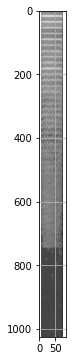

In [19]:
# Plot Spectrogram of audio to test
plt.figure(figsize=(10,6))
plt.imshow(20*specgram.log10().numpy(), cmap='gray')
plt.grid()

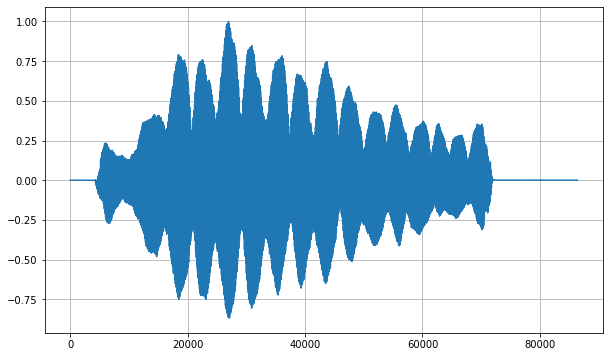

In [20]:
# Plot Waveform of audio to test
plt.figure(figsize=(10,6))
plt.plot(audio_to_test[0,0,:])
plt.grid()

In [21]:
# Listen to audio
ipd.Audio(audio_to_test[0,0,:], rate=44100) # load a local WAV file